In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from transformers import AutoProcessor, Blip2ForConditionalGeneration

%matplotlib inline

## Loading data

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Visualization

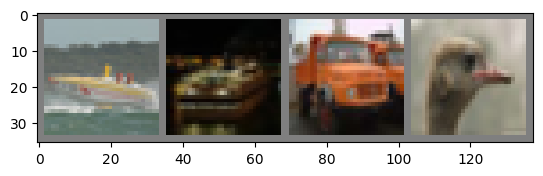

ship  ship  truck bird 


In [4]:
def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## CNN

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Model()

## Training

In [12]:
def training(count_epoch, criterion, optimizer):
    for epoch in range(count_epoch):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:    
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Training Completed')
    return model

## Testing

In [8]:
def testing(model):
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    imshow(torchvision.utils.make_grid(images))
    print('Target: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))


    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1



    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for the class: {classname} is {accuracy} %')

## Тренируем и тестируем сеть с разными параметрами

- сеть № 1

[1,  2000] loss: 2.081
[1,  4000] loss: 1.876
[1,  6000] loss: 1.767
[1,  8000] loss: 1.660
[1, 10000] loss: 1.610
[1, 12000] loss: 1.583
[2,  2000] loss: 1.532
[2,  4000] loss: 1.530
[2,  6000] loss: 1.484
[2,  8000] loss: 1.465
[2, 10000] loss: 1.473
[2, 12000] loss: 1.421
[3,  2000] loss: 1.414
[3,  4000] loss: 1.392
[3,  6000] loss: 1.385
[3,  8000] loss: 1.379
[3, 10000] loss: 1.381
[3, 12000] loss: 1.355
[4,  2000] loss: 1.349
[4,  4000] loss: 1.305
[4,  6000] loss: 1.325
[4,  8000] loss: 1.288
[4, 10000] loss: 1.281
[4, 12000] loss: 1.289
Training Completed


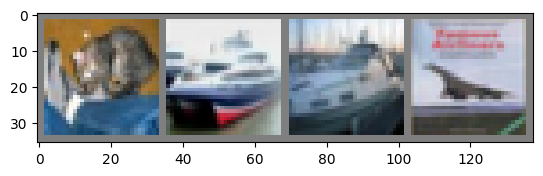

Target:  cat   ship  ship  plane
Predicted:  cat   ship  ship  car  
Accuracy for the class: plane is 61.9 %
Accuracy for the class: car is 77.7 %
Accuracy for the class: bird is 21.5 %
Accuracy for the class: cat is 23.2 %
Accuracy for the class: deer is 48.8 %
Accuracy for the class: dog is 65.3 %
Accuracy for the class: frog is 60.8 %
Accuracy for the class: horse is 66.6 %
Accuracy for the class: ship is 48.2 %
Accuracy for the class: truck is 59.9 %


In [14]:
model = Model()
optimizer=optim.Adam(model.parameters(), lr=0.0001)
trained_model = training(4, nn.CrossEntropyLoss(), optimizer)
testing(trained_model)

- сеть № 2

[1,  2000] loss: 1.830
[1,  4000] loss: 1.600
[1,  6000] loss: 1.538
[1,  8000] loss: 1.458
[1, 10000] loss: 1.418
[1, 12000] loss: 1.387
[2,  2000] loss: 1.335
[2,  4000] loss: 1.296
[2,  6000] loss: 1.287
[2,  8000] loss: 1.288
[2, 10000] loss: 1.259
[2, 12000] loss: 1.240
[3,  2000] loss: 1.186
[3,  4000] loss: 1.192
[3,  6000] loss: 1.173
[3,  8000] loss: 1.174
[3, 10000] loss: 1.167
[3, 12000] loss: 1.194
[4,  2000] loss: 1.122
[4,  4000] loss: 1.107
[4,  6000] loss: 1.102
[4,  8000] loss: 1.118
[4, 10000] loss: 1.143
[4, 12000] loss: 1.118
Training Completed


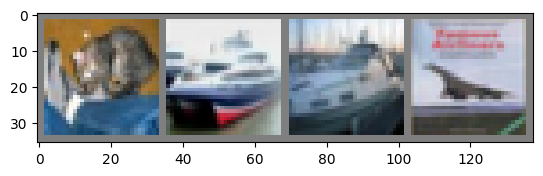

Target:  cat   ship  ship  plane
Predicted:  cat   ship  ship  plane
Accuracy for the class: plane is 62.1 %
Accuracy for the class: car is 77.3 %
Accuracy for the class: bird is 41.9 %
Accuracy for the class: cat is 43.9 %
Accuracy for the class: deer is 40.4 %
Accuracy for the class: dog is 41.2 %
Accuracy for the class: frog is 75.6 %
Accuracy for the class: horse is 64.4 %
Accuracy for the class: ship is 77.7 %
Accuracy for the class: truck is 63.0 %


In [15]:
model = Model()
optimizer=optim.Adam(model.parameters(), lr=0.001)
trained_model = training(4, nn.CrossEntropyLoss(), optimizer)
testing(trained_model)

[1,  2000] loss: 1.860
[1,  4000] loss: 1.603
[1,  6000] loss: 1.538
[1,  8000] loss: 1.493
[1, 10000] loss: 1.446
[1, 12000] loss: 1.415
[2,  2000] loss: 1.341
[2,  4000] loss: 1.336
[2,  6000] loss: 1.330
[2,  8000] loss: 1.300
[2, 10000] loss: 1.290
[2, 12000] loss: 1.284
[3,  2000] loss: 1.189
[3,  4000] loss: 1.200
[3,  6000] loss: 1.235
[3,  8000] loss: 1.197
[3, 10000] loss: 1.200
[3, 12000] loss: 1.192
[4,  2000] loss: 1.126
[4,  4000] loss: 1.114
[4,  6000] loss: 1.140
[4,  8000] loss: 1.139
[4, 10000] loss: 1.143
[4, 12000] loss: 1.147
[5,  2000] loss: 1.061
[5,  4000] loss: 1.078
[5,  6000] loss: 1.070
[5,  8000] loss: 1.102
[5, 10000] loss: 1.093
[5, 12000] loss: 1.072
[6,  2000] loss: 1.005
[6,  4000] loss: 1.046
[6,  6000] loss: 1.067
[6,  8000] loss: 1.021
[6, 10000] loss: 1.049
[6, 12000] loss: 1.058
[7,  2000] loss: 0.989
[7,  4000] loss: 0.990
[7,  6000] loss: 0.997
[7,  8000] loss: 1.022
[7, 10000] loss: 1.034
[7, 12000] loss: 1.043
[8,  2000] loss: 0.953
[8,  4000] 

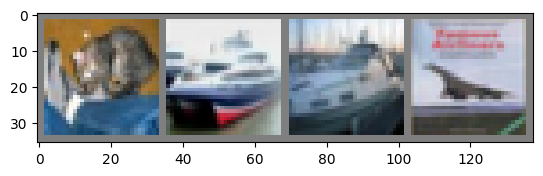

Target:  cat   ship  ship  plane
Predicted:  cat   ship  car   plane
Accuracy for the class: plane is 59.5 %
Accuracy for the class: car is 77.9 %
Accuracy for the class: bird is 46.2 %
Accuracy for the class: cat is 40.0 %
Accuracy for the class: deer is 53.5 %
Accuracy for the class: dog is 55.8 %
Accuracy for the class: frog is 75.2 %
Accuracy for the class: horse is 58.6 %
Accuracy for the class: ship is 72.0 %
Accuracy for the class: truck is 66.5 %


In [16]:
model = Model()
optimizer=optim.Adam(model.parameters(), lr=0.001)
trained_model = training(8, nn.CrossEntropyLoss(), optimizer)
testing(trained_model)